# Assignment

## Imports

In [ ]:
import pandas as pd
from pandas_datareader.data import DataReader
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, date, timedelta
import seaborn as sns
plt.style.use('seaborn-colorblind')

## NASDAQ Leveraged

In [ ]:
#We are using a CSV file that contains TQQQ data. This is a leveraged ETF for the NASDAQ 100.

In [ ]:
tqqq = pd.read_csv('HistoricalData_TQQQ.csv', parse_dates=['Date']).dropna()

In [ ]:
#Creating a function that shows the first and last 5 rows to ensure data is accurate and shape at the end. 
def see_first_last_rows_shape(dataframe):
    print(dataframe.head(5).append(dataframe.tail(5)))
    print(f'Dataframe Shape: {dataframe.shape}')

In [ ]:
tqqq.sort_values('Date', ascending=True, inplace=True) #Start with earliest date. 

In [ ]:
tqqq.set_index('Date', inplace=True) #set index

In [ ]:
see_first_last_rows_shape(tqqq) 

In [ ]:
#We will use this later when comparing the S&P500 leveraged vs NASDAQ 100 Leveraged(TQQQ)

## Part I - SP500 Data + Leveraged Calculations

In [ ]:
start = date(1970, 1, 1) 
end=date(2021, 11, 19)

In [ ]:
sp500_df = DataReader('^GSPC', 'yahoo', start, end) #Using DataReader, we import the S&P 500 using the start and end variables.

In [ ]:
see_first_last_rows_shape(sp500_df)

In [ ]:
sp500_df.info()

In [ ]:
sp500_df.isna().any()

In [ ]:
sp500_df.duplicated().sum()

## We only require the 'Close' column for our calculations

In [ ]:
sp500_df.drop(['High', 'Low', 'Open','Volume','Adj Close'], axis=1, inplace=True)

In [ ]:
#Calculating the Percentage change data for the S&P500 day to day. 
#We then multiply the percentage change by 3 to see the Leveraged data. This will mimic a Leveraged S&P 500.
sp500_df['Daily Change'] = (sp500_df['Close'].pct_change()) + 1
sp500_df['Daily Change x3'] = ((sp500_df['Close'].pct_change())*3 ) +1

In [ ]:
sp500_df = sp500_df.fillna(1) #Setting the 2 first rows to 1 so they start equally. 
see_first_last_rows_shape(sp500_df) #view data


### Creating the Management fee 

In [ ]:
#TQQQ has a net management fee of 0.95% on their factsheet. For this analysis, we'll assume a management fee of 1%. 

In [ ]:
#Adding the management fee at the last hour of each year using date_range().This creates a datatime index with the required times.
begin_date = datetime(1970,12,31,23)
end_date = datetime(2020, 12, 31, 23)
year_end = pd.date_range(begin_date, freq='Y', end=end_date)

In [ ]:
year_end_dates = pd.DataFrame(year_end, columns=['Date']) #converting to a dataframe

In [ ]:
see_first_last_rows_shape(year_end_dates) #To ensure first and last dates are correct

In [ ]:
#outer join to merge the management fee dates from the new dataframe with the required dates to the S&P 500 dataframe.
#outer join allows us to keep all the dates together.Dates sorted so the managment fee dates correctly get sorted.
sp500_df = sp500_df.merge(year_end_dates, on='Date', how='outer').sort_values('Date') 

In [ ]:
sp500_df.set_index('Date', inplace=True)

In [ ]:
print(sp500_df.isna().sum()) 
#As expected, the new dataframe creates NaN values along the columns. We'll fill the managment fee into the NaN values.

In [ ]:
sp500_df['Daily Change'] = sp500_df['Daily Change'].fillna(1) #No change in price for the normal S&P500, 1x multiplier added.
sp500_df['Daily Change x3'] = sp500_df['Daily Change x3'].fillna(0.99) #Multiplier of 0.99 added for the 1% managment fee.

In [ ]:
print(sp500_df.isna().sum())

In [ ]:
sp500_df['Close'].interpolate(method='index' ,inplace=True) #Close still contains NaN values. Interpolate used to fill NaNs.

In [ ]:
sp500_df.isna().sum()

In [ ]:
#we need to find the cumulative return of the sp500 day by day. A for loop appends these to a list.
change_accum_list = []
for rows in sp500_df['Daily Change']:
    change_accum_list.append(rows)
    
#Now the cumulative returns of the leveraged sp500
changex3_accum_list = []
for rows2 in sp500_df['Daily Change x3']:
    changex3_accum_list.append(rows2) 

In [ ]:
change_prod = np.cumprod(change_accum_list) #np.cumprod gives us the cumulative product of each value in the list.

In [ ]:
change_prodx3 = np.cumprod(changex3_accum_list) 

In [ ]:
sp500_df['Daily_change_prod'] = np.array(change_prod) #converting the cumulative product into a column on the dataframe.
sp500_df['Daily_change_prodx3'] = np.array(change_prodx3)

In [ ]:
#Here we assume an initial investment of 10k. We multiply this by the cumulative product to give us the returns of a 10k investment
sp500_df['SP500_invest_normal'] = sp500_df['Daily_change_prod'] * 10000
sp500_df['SP500_invest_leveraged'] = sp500_df['Daily_change_prodx3'] * 10000

In [ ]:
sp500_df.tail() #viewing the last 5 rows to see the final return on 2021-11-19

In [ ]:
#Plotted to visualise the returns over the 50 year period.
plt.figure(figsize=(12,8))
sns.lineplot(x= sp500_df.index, y= "SP500_invest_normal", data = sp500_df, 
                  label = 'SP500_invest_normal')
sns.lineplot(x= sp500_df.index, y= "SP500_invest_leveraged", data = sp500_df, 
                  label = 'SP500_invest_leveraged').set_title("S&P500 VS S&P500 Leveraged x3")
plt.legend()

plt.show()

In [ ]:
#periods of interest(dataframes sliced to capture the min and max of the periods of interest).
#This allows us to see the percentage decrease between the maximum and minumum value for periods where the market had a downturn.
def percentage_decrease(dataframe, column, first_year, last_year):
    dftemp = dataframe[first_year:last_year]
    max_val = dftemp[column].max()
    min_val = dftemp[column].min()
    difference = (((min_val - max_val)/max_val)*-100)
    difference = round(difference , 2)
    print(f'The {column} decreased {difference}% between {first_year} and {last_year}.' )


In [ ]:
percentage_decrease(sp500_df, 'SP500_invest_leveraged', '1999', '2003')

In [ ]:
percentage_decrease(sp500_df, 'SP500_invest_normal', '1999', '2003')

In [ ]:
percentage_decrease(sp500_df, 'SP500_invest_leveraged', '2007', '2011')

In [ ]:
percentage_decrease(sp500_df, 'SP500_invest_normal', '2007', '2011')

In [ ]:
#The first plot was difficult to see so the entire plot was sliced into 10 year periods and visualised for better interpretation.
columns = ['SP500_invest_normal', 'SP500_invest_leveraged' ]
periods = ['1970', '1980','1990', '2000', '2010','2020']
count = 1

for period in periods:
    if period == periods[-1]:
        break
    else:
        temp_df = sp500_df[period:periods[count]]
        count = count+1
        plt.subplots(figsize=(14, 9))
        sns.lineplot(data = temp_df, x=temp_df.index, y='SP500_invest_normal', label = 'SP500_invest_normal')
        sns.lineplot(data = temp_df, x=temp_df.index, y='SP500_invest_leveraged', label = 'SP500_invest_leveraged')
        plt.legend()
        plt.show()
    


In [ ]:
#Part II - TQQQ VS SP 500 Leveraged x3
see_first_last_rows_shape(tqqq)

In [ ]:
tqqq.drop(['High', 'Low', 'Open','Volume'], axis=1, inplace=True) #Dropping columns that are not required. 

In [ ]:
tqqq['Daily Change'] = (tqqq['Close/Last'].pct_change()) + 1 #calculating percentage change

In [ ]:
#adding the leveraged S&P 500 into its own DF and slicing the years to match TQQQ
temp_sp500x3 = sp500_df[['Daily Change x3']]['2011-11-21':'2021-11-19'] 

In [ ]:
tqqq_vs_sp500x3 = tqqq.merge(temp_sp500x3, on='Date', how='outer').sort_values('Date') #Outer merge to capture all dates in
#the S&P dataframe.

In [ ]:
see_first_last_rows_shape(tqqq_vs_sp500x3)

In [ ]:
tqqq_vs_sp500x3 = tqqq_vs_sp500x3.rename(columns={'Daily Change': 'tqqq_change_daily', 'Daily Change x3': 'sp500x3_change_daily'})

In [ ]:
tqqq_vs_sp500x3.drop(['Close/Last'], axis=1, inplace=True) #close column not required.

In [ ]:
tqqq_vs_sp500x3.iloc[0, 0] = 1 #Starting both at 1 equal numbers.
tqqq_vs_sp500x3.iloc[0, 1] = 1

In [ ]:
tqqq_vs_sp500x3['tqqq_change_daily'].fillna(0.99, inplace=True) #adding managment fee mulitplier for TQQQ in place of the NaNs,
#these NAN values would have come from the S&P 500 dataframe when doing the outer merge (the purpose of doing an outer merge)

In [ ]:
see_first_last_rows_shape(tqqq_vs_sp500x3)

In [ ]:
#we need to find the cumulative return of TQQQ day by day, similar to what we did with the S&P 500 dataframe
tqqq_accum_list = []
for trows in tqqq_vs_sp500x3['tqqq_change_daily']:
    tqqq_accum_list.append(trows)
    
#Now the cumulative returns on the leveraged sp500
sp500x3_accum_list = []
for sprows in tqqq_vs_sp500x3['sp500x3_change_daily']:
    sp500x3_accum_list.append(sprows)

In [ ]:
tqqq_vs_sp500x3['tqqq_accum_total'] = np.cumprod(tqqq_vs_sp500x3['tqqq_change_daily'])
tqqq_vs_sp500x3['sp500_accum_total'] = np.cumprod(tqqq_vs_sp500x3['sp500x3_change_daily'])

In [ ]:
tqqq_vs_sp500x3['tqqq_10k_invest'] = tqqq_vs_sp500x3['tqqq_accum_total'] * 10000
tqqq_vs_sp500x3['sp500x3_10k_invest'] = tqqq_vs_sp500x3['sp500_accum_total'] * 10000

In [ ]:
see_first_last_rows_shape(tqqq_vs_sp500x3)

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "tqqq_10k_invest", data = tqqq_vs_sp500x3, 
                  label = 'TQQQ 10k Investment')
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "sp500x3_10k_invest", data = tqqq_vs_sp500x3, 
                  label = 'Leveraged SP500 10k Investment').set_title("TQQQ VS S&P500 Leveraged x3")
plt.legend()

plt.show()

In [ ]:
#Dataframe to visualise to first few years of returns as the are unclear from the 10 year visualisation.
tqqq_vs_sp500x3_slice = tqqq_vs_sp500x3[:'2014']

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(x= tqqq_vs_sp500x3_slice.index, y= "tqqq_10k_invest", data = tqqq_vs_sp500x3_slice, 
                  label = 'TQQQ 10k Investment')
sns.lineplot(x= tqqq_vs_sp500x3_slice.index, y= "sp500x3_10k_invest", data = tqqq_vs_sp500x3_slice, 
                  label = 'Leveraged SP500 10k Investment').set_title("TQQQ VS S&P500 Leveraged x3")
plt.legend()

plt.show()

In [ ]:
percentage_decrease(tqqq_vs_sp500x3, 'tqqq_10k_invest', '2020-01', '2020-04')

In [ ]:
percentage_decrease(tqqq_vs_sp500x3, 'sp500x3_10k_invest', '2020-01', '2020-04')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

sns.lineplot(x= tqqq_vs_sp500x3.index, y= "tqqq_change_daily", data = tqqq_vs_sp500x3, 
                  label = 'TQQQ 10k Investment', ax=ax[0]).set_title("TQQQ VS S&P500 Leveraged x3 Daily Change")
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "sp500x3_change_daily", data = tqqq_vs_sp500x3, 
                  label = 'Leveraged SP500 10k Investment', ax=ax[1])
plt.legend()

plt.show()

In [ ]:
! jupyter nbconvert --to script leveraged_etfs.ipynb

            Close/Last    Volume      Open      High       Low
Date                                                          
2011-11-21      1.3175  67924909    1.3446    1.3473    1.2765
2011-11-22      1.3290  80159264    1.3060    1.3435    1.2850
2011-11-23      1.2406  77453884    1.3017    1.3054    1.2396
2011-11-25      1.2125  30887953    1.2271    1.2685    1.2125
2011-11-28      1.3377  65598537    1.3012    1.3437    1.3004
2021-11-15    165.4000  34864550  166.9100  167.3100  162.0900
2021-11-16    168.8200  25795400  164.2900  169.4083  164.0600
2021-11-17    169.0200  28983970  169.2100  171.6850  167.7900
2021-11-18    174.1900  43420840  171.6800  174.9000  168.7700
2021-11-19    177.1400  32303580  176.4300  178.8701  175.3200
Dataframe Shape: (2517, 5)
                   High          Low         Open        Close      Volume  \
Date                                                                         
1970-01-02    93.540001    91.790001     0.000000    93.00000

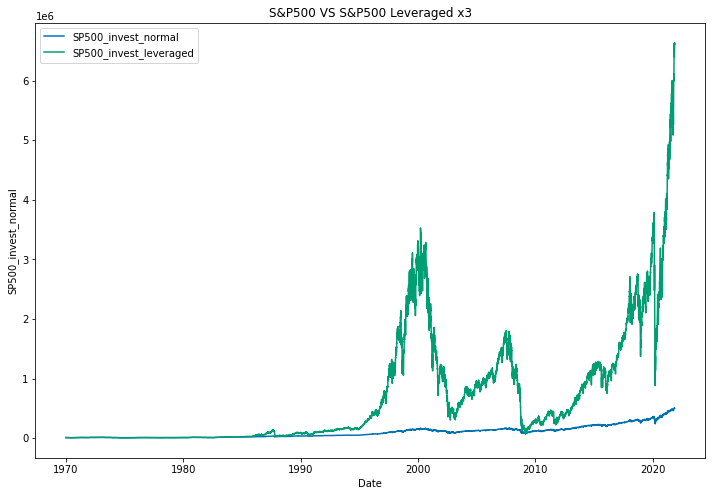

The SP500_invest_leveraged decreased 91.38% between 1999 and 2003.
The SP500_invest_normal decreased 49.15% between 1999 and 2003.
The SP500_invest_leveraged decreased 95.82% between 2007 and 2011.
The SP500_invest_normal decreased 56.78% between 2007 and 2011.


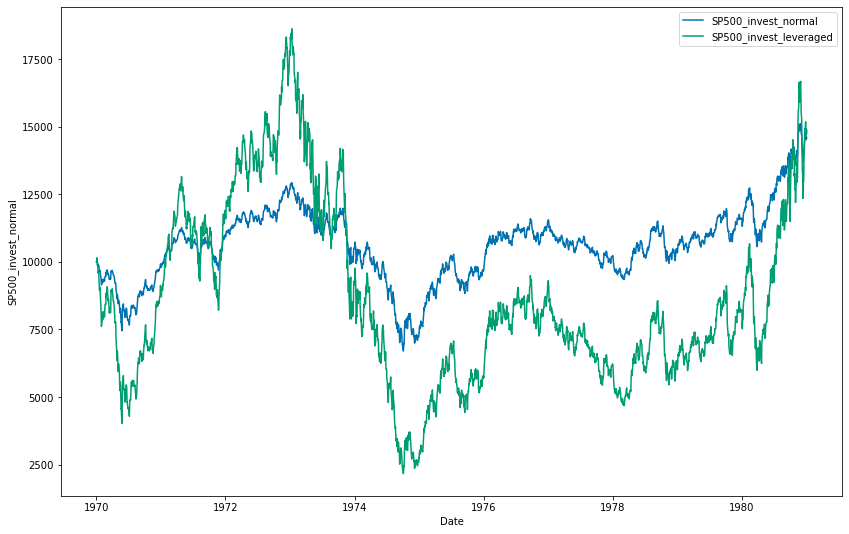

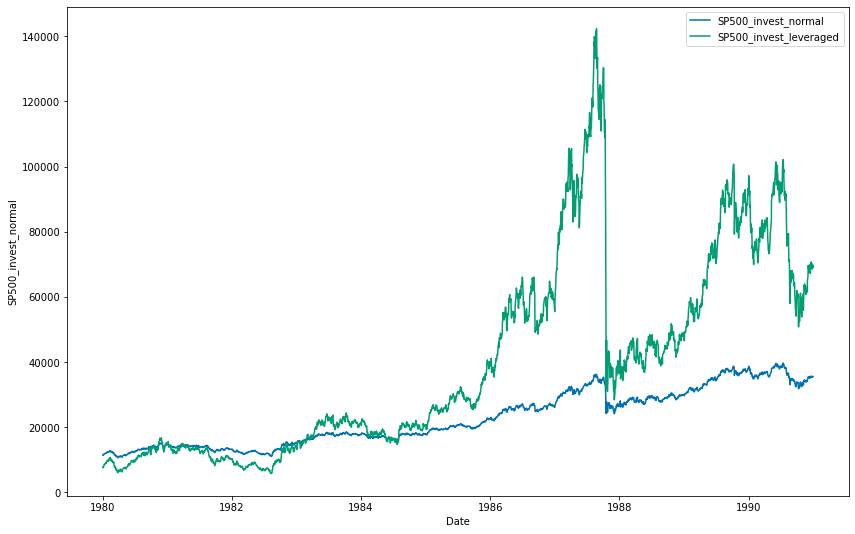

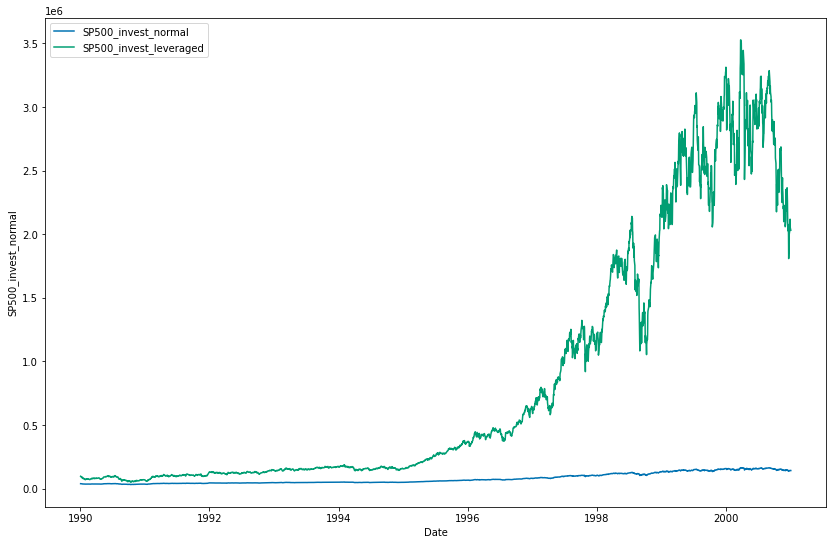

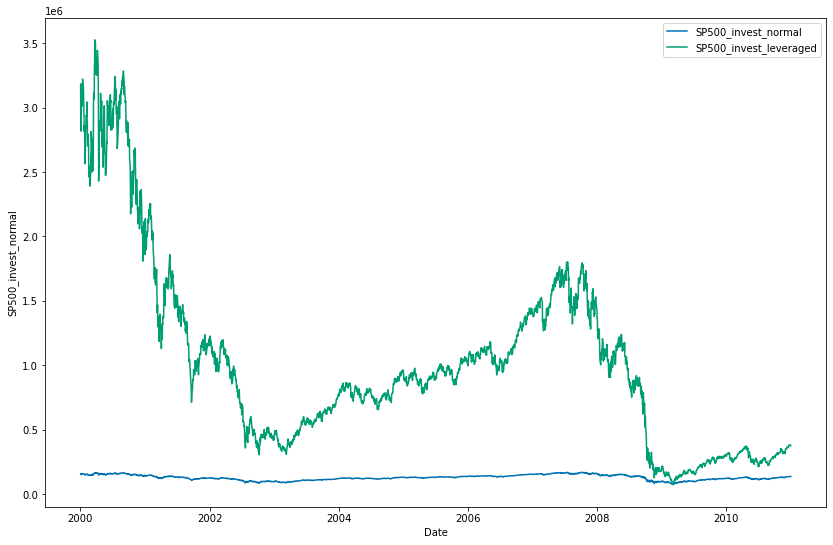

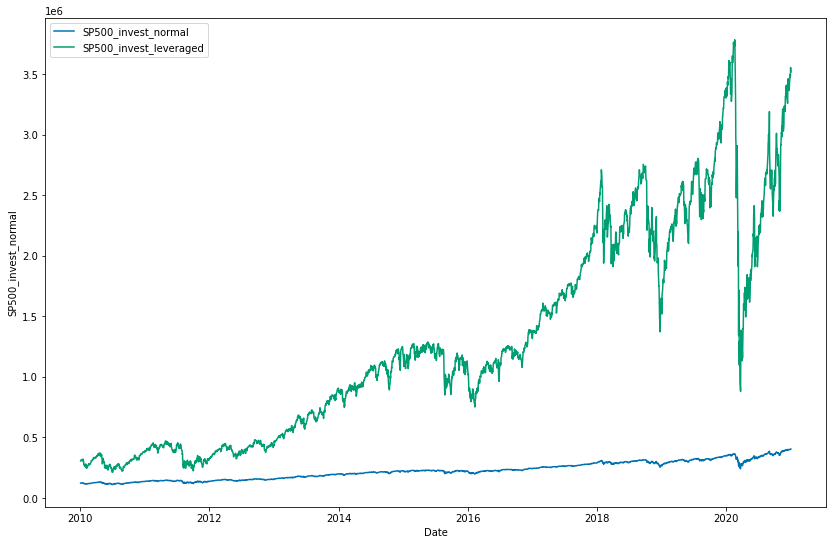

            Close/Last    Volume      Open      High       Low
Date                                                          
2011-11-21      1.3175  67924909    1.3446    1.3473    1.2765
2011-11-22      1.3290  80159264    1.3060    1.3435    1.2850
2011-11-23      1.2406  77453884    1.3017    1.3054    1.2396
2011-11-25      1.2125  30887953    1.2271    1.2685    1.2125
2011-11-28      1.3377  65598537    1.3012    1.3437    1.3004
2021-11-15    165.4000  34864550  166.9100  167.3100  162.0900
2021-11-16    168.8200  25795400  164.2900  169.4083  164.0600
2021-11-17    169.0200  28983970  169.2100  171.6850  167.7900
2021-11-18    174.1900  43420840  171.6800  174.9000  168.7700
2021-11-19    177.1400  32303580  176.4300  178.8701  175.3200
Dataframe Shape: (2517, 5)
            Close/Last  Daily Change  Daily Change x3
Date                                                 
2011-11-21      1.3175           NaN         0.944055
2011-11-22      1.3290      1.008729         0.987577
2

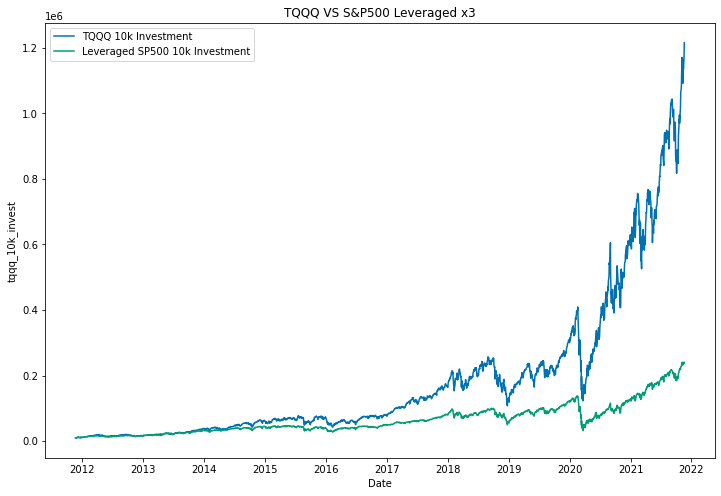

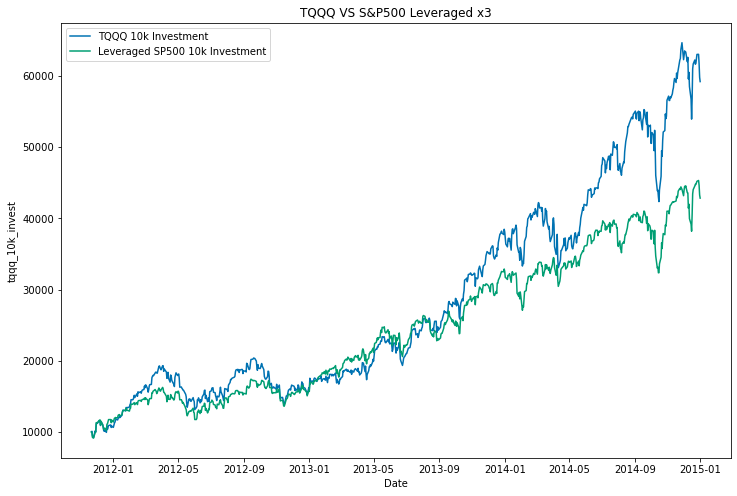

The tqqq_10k_invest decreased 69.92% between 2020-01 and 2020-04.
The sp500x3_10k_invest decreased 76.74% between 2020-01 and 2020-04.


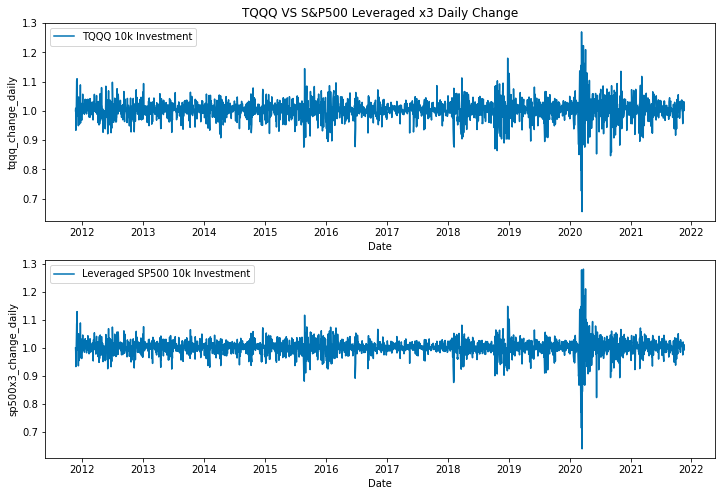

In [1]:

import pandas as pd
from pandas_datareader.data import DataReader
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, date, timedelta
import seaborn as sns
plt.style.use('seaborn-colorblind')


# ## NASDAQ Leveraged
#We are using a CSV file that contains TQQQ data. This is a leveraged ETF for the NASDAQ 100.
tqqq = pd.read_csv('HistoricalData_TQQQ.csv', parse_dates=['Date']).dropna()

#Creating a function that shows the first and last 5 rows to ensure data is accurate and shape at the end. 
def see_first_last_rows_shape(dataframe):
    print(dataframe.head(5).append(dataframe.tail(5)))
    print(f'Dataframe Shape: {dataframe.shape}')

tqqq.sort_values('Date', ascending=True, inplace=True) #Start with earliest date. 
tqqq.set_index('Date', inplace=True) #set index
see_first_last_rows_shape(tqqq)
#We will use this later when comparing the S&P500 leveraged vs NASDAQ 100 Leveraged(TQQQ)

# Part I - SP500 Data + Leveraged Calculations

start = date(1970, 1, 1) 
end=date(2021, 11, 19)
sp500_df = DataReader('^GSPC', 'yahoo', start, end) #Using DataReader, we import the S&P 500 using the start and end variables.
see_first_last_rows_shape(sp500_df)

sp500_df.info()

print(sp500_df.isna().any())

print(sp500_df.duplicated().sum())

# ## We only require the 'Close' column for our calculations
sp500_df.drop(['High', 'Low', 'Open','Volume','Adj Close'], axis=1, inplace=True)

#Calculating the Percentage change data for the S&P500 day to day. 
#We then multiply the percentage change by 3 to see the Leveraged data. This will mimic a Leveraged S&P 500.
sp500_df['Daily Change'] = (sp500_df['Close'].pct_change()) + 1
sp500_df['Daily Change x3'] = ((sp500_df['Close'].pct_change())*3 ) +1

sp500_df = sp500_df.fillna(1) #Setting the 2 first rows to 1 so they start equally. 
see_first_last_rows_shape(sp500_df) #view data

# ### Creating the Management fee
#TQQQ has a net management fee of 0.95% on their factsheet. For this analysis, we'll assume a management fee of 1%.
#Adding the management fee at the last hour of each year using date_range().This creates a datatime index with the required times.
begin_date = datetime(1970,12,31,23)
end_date = datetime(2020, 12, 31, 23)
year_end = pd.date_range(begin_date, freq='Y', end=end_date)

year_end_dates = pd.DataFrame(year_end, columns=['Date']) #converting to a dataframe

see_first_last_rows_shape(year_end_dates) #To ensure first and last dates are correct

#outer join to merge the management fee dates from the new dataframe with the required dates to the S&P 500 dataframe.
#outer join allows us to keep all the dates together.Dates sorted so the managment fee dates correctly get sorted.
sp500_df = sp500_df.merge(year_end_dates, on='Date', how='outer').sort_values('Date') 

sp500_df.set_index('Date', inplace=True)

print(sp500_df.isna().sum()) 
#As expected, the new dataframe creates NaN values along the columns. We'll fill the managment fee into the NaN values.


sp500_df['Daily Change'] = sp500_df['Daily Change'].fillna(1) #No change in price for the normal S&P500, 1x multiplier added.
sp500_df['Daily Change x3'] = sp500_df['Daily Change x3'].fillna(0.99) #Multiplier of 0.99 added for the 1% managment fee.

print(sp500_df.isna().sum())

sp500_df['Close'].interpolate(method='index' ,inplace=True) #Close still contains NaN values. Interpolate used to fill NaNs.

sp500_df.isna().sum()

#we need to find the cumulative return of the sp500 day by day. A for loop appends these to a list.
change_accum_list = []
for rows in sp500_df['Daily Change']:
    change_accum_list.append(rows)
    
#Now the cumulative returns of the leveraged sp500
changex3_accum_list = []
for rows2 in sp500_df['Daily Change x3']:
    changex3_accum_list.append(rows2) 

change_prod = np.cumprod(change_accum_list) #np.cumprod gives us the cumulative product of each value in the list.

change_prodx3 = np.cumprod(changex3_accum_list) 

sp500_df['Daily_change_prod'] = np.array(change_prod) #converting the cumulative product into a column on the dataframe.
sp500_df['Daily_change_prodx3'] = np.array(change_prodx3)

#Here we assume an initial investment of 10k. We multiply this by the cumulative product to give us the returns of a 10k investment
sp500_df['SP500_invest_normal'] = sp500_df['Daily_change_prod'] * 10000
sp500_df['SP500_invest_leveraged'] = sp500_df['Daily_change_prodx3'] * 10000

sp500_df.tail() #viewing the last 5 rows to see the final return on 2021-11-19

#Plotted to visualise the returns over the 50 year period.
plt.figure(figsize=(12,8))
sns.lineplot(x= sp500_df.index, y= "SP500_invest_normal", data = sp500_df, 
                  label = 'SP500_invest_normal')
sns.lineplot(x= sp500_df.index, y= "SP500_invest_leveraged", data = sp500_df, 
                  label = 'SP500_invest_leveraged').set_title("S&P500 VS S&P500 Leveraged x3")
plt.legend()

plt.show()

#periods of interest(dataframes sliced to capture the min and max of the periods of interest).
#This allows us to see the percentage decrease between the maximum and minumum value for periods where the market had a downturn.
def percentage_decrease(dataframe, column, first_year, last_year):
    dftemp = dataframe[first_year:last_year]
    max_val = dftemp[column].max()
    min_val = dftemp[column].min()
    difference = (((min_val - max_val)/max_val)*-100)
    difference = round(difference , 2)
    print(f'The {column} decreased {difference}% between {first_year} and {last_year}.' )

percentage_decrease(sp500_df, 'SP500_invest_leveraged', '1999', '2003')

percentage_decrease(sp500_df, 'SP500_invest_normal', '1999', '2003')

percentage_decrease(sp500_df, 'SP500_invest_leveraged', '2007', '2011')

percentage_decrease(sp500_df, 'SP500_invest_normal', '2007', '2011')

#The first plot was difficult to see so the entire plot was sliced into 10 year periods and visualised for better interpretation.
columns = ['SP500_invest_normal', 'SP500_invest_leveraged' ]
periods = ['1970', '1980','1990', '2000', '2010','2020']
count = 1

for period in periods:
    if period == periods[-1]:
        break
    else:
        temp_df = sp500_df[period:periods[count]]
        count = count+1
        plt.subplots(figsize=(14, 9))
        sns.lineplot(data = temp_df, x=temp_df.index, y='SP500_invest_normal', label = 'SP500_invest_normal')
        sns.lineplot(data = temp_df, x=temp_df.index, y='SP500_invest_leveraged', label = 'SP500_invest_leveraged')
        plt.legend()
        plt.show()
    

#Part II - TQQQ VS SP 500 Leveraged x3
see_first_last_rows_shape(tqqq)

tqqq.drop(['High', 'Low', 'Open','Volume'], axis=1, inplace=True) #Dropping columns that are not required. 

tqqq['Daily Change'] = (tqqq['Close/Last'].pct_change()) + 1 #calculating percentage change

#adding the leveraged S&P 500 into its own DF and slicing the years to match TQQQ
temp_sp500x3 = sp500_df[['Daily Change x3']]['2011-11-21':'2021-11-19'] 

tqqq_vs_sp500x3 = tqqq.merge(temp_sp500x3, on='Date', how='outer').sort_values('Date') #Outer merge to capture all dates in
#the S&P dataframe.

see_first_last_rows_shape(tqqq_vs_sp500x3)

tqqq_vs_sp500x3 = tqqq_vs_sp500x3.rename(columns={'Daily Change': 'tqqq_change_daily', 'Daily Change x3': 'sp500x3_change_daily'})

tqqq_vs_sp500x3.drop(['Close/Last'], axis=1, inplace=True) #close column not required.

tqqq_vs_sp500x3.iloc[0, 0] = 1 #Starting both at 1 equal numbers.
tqqq_vs_sp500x3.iloc[0, 1] = 1

tqqq_vs_sp500x3['tqqq_change_daily'].fillna(0.99, inplace=True) #adding managment fee mulitplier for TQQQ in place of the NaNs,
#these NAN values would have come from the S&P 500 dataframe when doing the outer merge (the purpose of doing an outer merge)

see_first_last_rows_shape(tqqq_vs_sp500x3)

#we need to find the cumulative return of TQQQ day by day, similar to what we did with the S&P 500 dataframe
tqqq_accum_list = []
for trows in tqqq_vs_sp500x3['tqqq_change_daily']:
    tqqq_accum_list.append(trows)
    
#Now the cumulative returns on the leveraged sp500
sp500x3_accum_list = []
for sprows in tqqq_vs_sp500x3['sp500x3_change_daily']:
    sp500x3_accum_list.append(sprows)

tqqq_vs_sp500x3['tqqq_accum_total'] = np.cumprod(tqqq_vs_sp500x3['tqqq_change_daily'])
tqqq_vs_sp500x3['sp500_accum_total'] = np.cumprod(tqqq_vs_sp500x3['sp500x3_change_daily'])

tqqq_vs_sp500x3['tqqq_10k_invest'] = tqqq_vs_sp500x3['tqqq_accum_total'] * 10000
tqqq_vs_sp500x3['sp500x3_10k_invest'] = tqqq_vs_sp500x3['sp500_accum_total'] * 10000

see_first_last_rows_shape(tqqq_vs_sp500x3)

plt.figure(figsize=(12,8))
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "tqqq_10k_invest", data = tqqq_vs_sp500x3, 
                  label = 'TQQQ 10k Investment')
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "sp500x3_10k_invest", data = tqqq_vs_sp500x3, 
                  label = 'Leveraged SP500 10k Investment').set_title("TQQQ VS S&P500 Leveraged x3")
plt.legend()

plt.show()

#Dataframe to visualise to first few years of returns as the are unclear from the 10 year visualisation.
tqqq_vs_sp500x3_slice = tqqq_vs_sp500x3[:'2014']

plt.figure(figsize=(12,8))
sns.lineplot(x= tqqq_vs_sp500x3_slice.index, y= "tqqq_10k_invest", data = tqqq_vs_sp500x3_slice, 
                  label = 'TQQQ 10k Investment')
sns.lineplot(x= tqqq_vs_sp500x3_slice.index, y= "sp500x3_10k_invest", data = tqqq_vs_sp500x3_slice, 
                  label = 'Leveraged SP500 10k Investment').set_title("TQQQ VS S&P500 Leveraged x3")
plt.legend()

plt.show()

percentage_decrease(tqqq_vs_sp500x3, 'tqqq_10k_invest', '2020-01', '2020-04')

percentage_decrease(tqqq_vs_sp500x3, 'sp500x3_10k_invest', '2020-01', '2020-04')

fig, ax = plt.subplots(2, 1, figsize=(12,8))
#plt.figure(figsize=(12,8))
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "tqqq_change_daily", data = tqqq_vs_sp500x3, 
                  label = 'TQQQ 10k Investment', ax=ax[0]).set_title("TQQQ VS S&P500 Leveraged x3 Daily Change")
sns.lineplot(x= tqqq_vs_sp500x3.index, y= "sp500x3_change_daily", data = tqqq_vs_sp500x3, 
                  label = 'Leveraged SP500 10k Investment', ax=ax[1])
plt.legend()

plt.show()
